In [1]:

import pandas as pd
import matplotlib as mpl
mpl.interactive(True)
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw as gsw
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


#
#Full res BB CTD data
#
d=pd.read_csv('Documents/Summer_2021/bb_data/bbmp_aggregated_profiles.csv')

#multindexing
multi_full=d.set_index(['time_string', 'pressure'])

#dealing with repeated values
multi=multi_full.groupby(level=multi_full.index.names).mean()
#multi = multi_full[~multi_full.index.duplicated(keep='last')]

#making the multidim xarray dataset
ds=xr.Dataset.from_dataframe(multi)
ds=ds.rename({'time_string':'time'})

years=np.arange(1999,2021)

#this is an array of colours transitioning from red to blue
colours=np.array(['#ff0000', '#ff004d', '#ff0077', '#ff009a', '#ff00e6', '#d500ff', '#ab00ff', '#7700ff', '#5e00ff', '#3c00ff', '#1100ff', '#0044ff', '#006fff', '#00b3ff'])



#defining the week long segments
winter_weeks=np.array(['12-01', '12-08', '12-15', '12-22', '12-29', '01-05' , '01-12', '01-19', '01-26', '02-02', '02-09', '02-16', '02-23'])
spring_weeks=np.array(['03-02', '03-09', '03-16', '03-23', '03-30', '04-06', '04-13', '04-20', '04-27', '05-04', '05-11', '05-18', '05-25'])
summer_weeks=np.array(['06-01', '06-08', '06-15', '06-22', '06-29', '07-06', '07-13', '07-20', '07-27', '08-03', '08-10', '08-17', '08-24', '08-31'])
fall_weeks=np.array(['09-07', '09-14', '09-21', '09-28', '10-05', '10-12', '10-19', '10-26', '11-02', '11-09', '11-16', '11-23', '11-30'])

season_weeks=np.append(np.append(np.append(winter_weeks, spring_weeks), summer_weeks), fall_weeks)

szn={}
for y in range(len(years)):
    szn[str(years[y])]={}

##slicing the data into the week long segments
for y in range(len(years)):
    for w in range(len(season_weeks)-1):
        szn[str(years[y])][season_weeks[w]] = ds.sel(time=slice(str(years[y]) + '-' + season_weeks[w], str(years[y]) + '-' + season_weeks[w+1]))

#initializing some empty arrays (filled with nans)
szn_mean_T={}
szn_mean_S={}
for w in range(len(season_weeks)):
  szn_mean_T[season_weeks[w]]=np.empty([1,276])
  szn_mean_T[season_weeks[w]][:]=np.nan
  szn_mean_S[season_weeks[w]] = np.empty([1, 276])
  szn_mean_S[season_weeks[w]][:]=np.nan

#appending all the years for a given week into an array
for w in range(len(season_weeks)-1):
  for y in range(len(years)):
      szn_mean_T[season_weeks[w]]=np.append(szn_mean_T[season_weeks[w]], szn[str(years[y])][season_weeks[w]].temperature, axis=0)
      szn_mean_S[season_weeks[w]]=np.append(szn_mean_S[season_weeks[w]],szn[str(years[y])][season_weeks[w]].salinity,axis=0)

#doing a depth plot of the number of datapoints
dp_count=np.empty([53,276])
for j in range(len(ds.pressure.values)):
    for i in range(len(season_weeks)):
        dp_count[i][j]=len(szn_mean_T[season_weeks[i]][:,j][~np.isnan(szn_mean_T[season_weeks[i]][:,j])])
        

#rejecting if there is less than 10 datapoints for any given week/depth combo
for w in range(len(season_weeks)-1):
    for y in range(len(szn_mean_T[season_weeks[w]])):
        for j in range(len(ds.pressure.values)):
            if dp_count[w][j] >= 10:
                szn_mean_T[season_weeks[w]][y][j]=szn_mean_T[season_weeks[w]][y][j]
                szn_mean_S[season_weeks[w]][y][j]=szn_mean_S[season_weeks[w]][y][j]
            else:
                szn_mean_T[season_weeks[w]][y][j]=np.nan
                szn_mean_S[season_weeks[w]][y][j]=np.nan

#taking the mean across the years for each week
for w in range(len(season_weeks)-1):
  szn_mean_T[season_weeks[w]]=np.nanmean(szn_mean_T[season_weeks[w]], axis=0)
  szn_mean_S[season_weeks[w]] = np.nanmean(szn_mean_S[season_weeks[w]], axis=0)


<ipython-input-1-397b7f26e145>:108: RuntimeWarning: Mean of empty slice
  szn_mean_T[season_weeks[w]]=np.nanmean(szn_mean_T[season_weeks[w]], axis=0)
<ipython-input-1-397b7f26e145>:109: RuntimeWarning: Mean of empty slice
  szn_mean_S[season_weeks[w]] = np.nanmean(szn_mean_S[season_weeks[w]], axis=0)


In [2]:
#CTD profiles

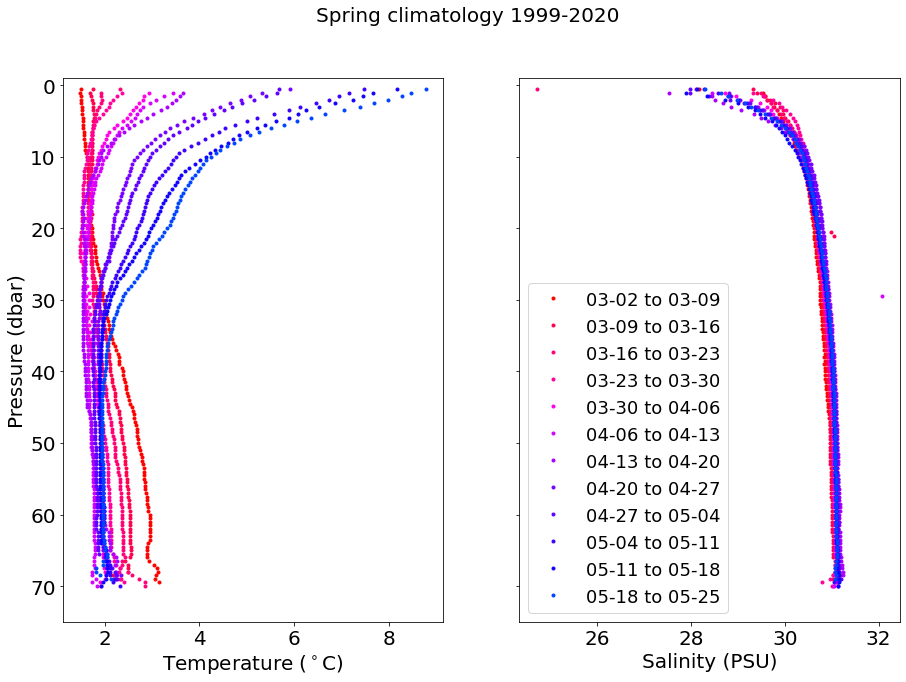

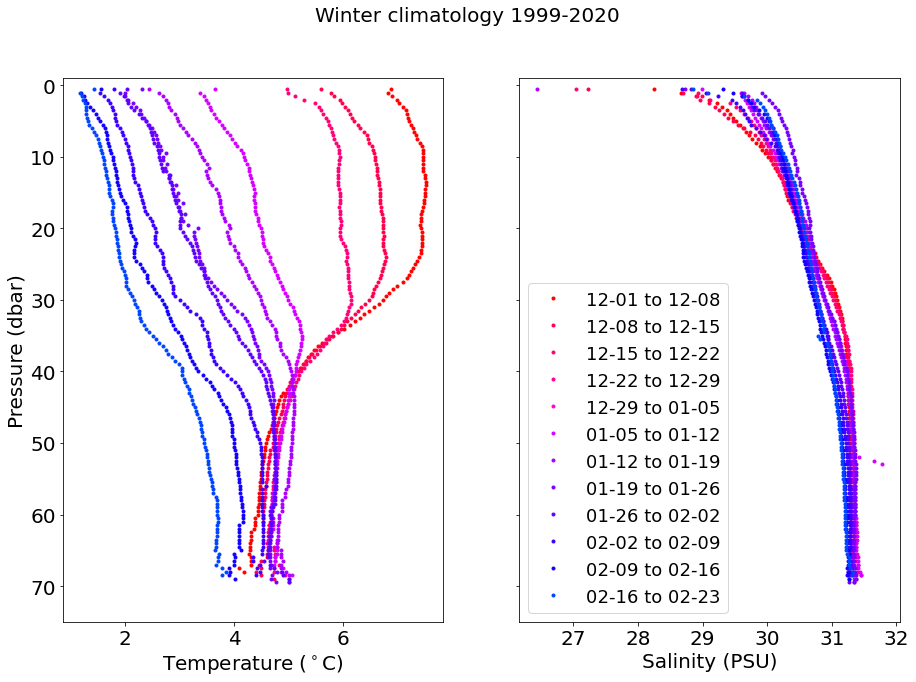

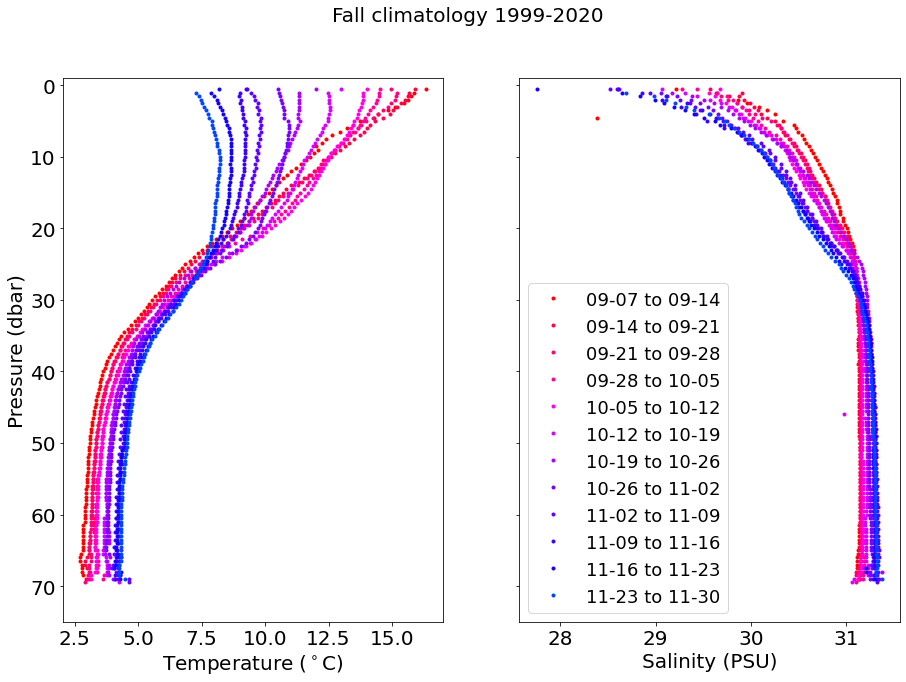

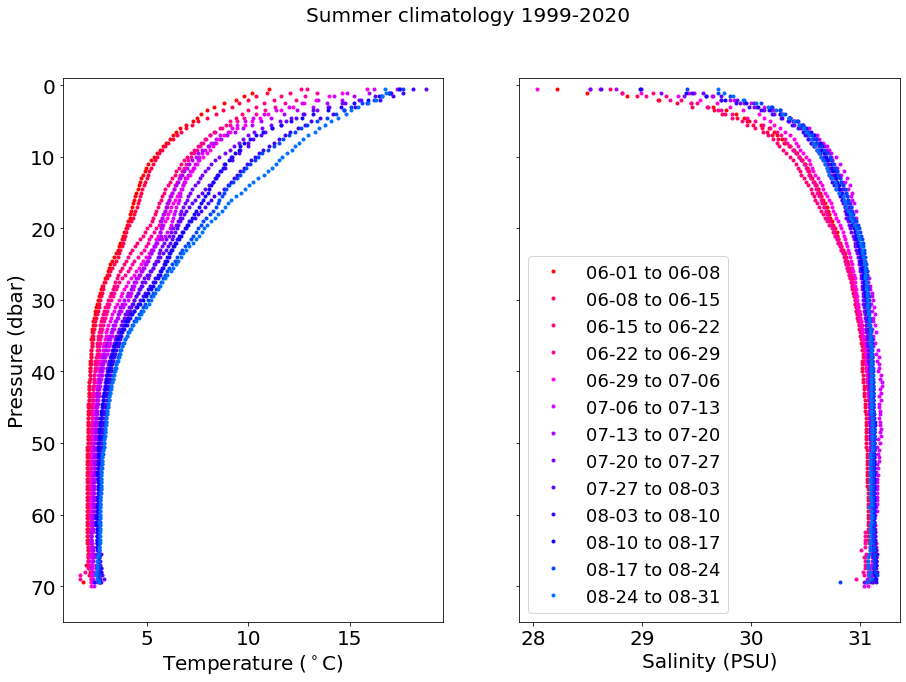

In [3]:

#plotting the climatologies for each season
##                FIGURES 13-16
plt.close()
which_season_weeks={}
which_season_weeks['spring']=spring_weeks
which_season_weeks['winter']=winter_weeks
which_season_weeks['fall']=fall_weeks
which_season_weeks['summer']=summer_weeks
which_season_title={}
which_season_title['spring']='Spring climatology 1999-2020'
which_season_title['winter']='Winter climatology 1999-2020'
which_season_title['fall']='Fall climatology 1999-2020'
which_season_title['summer']='Summer climatology 1999-2020'

for s in which_season_weeks.keys():
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
    for w in range(len(which_season_weeks[s])-1):
      ax1.plot(szn_mean_T[which_season_weeks[s][w]], ds.pressure.values, '.', c=colours[w])
      ax2.plot(szn_mean_S[which_season_weeks[s][w]], ds.pressure.values, '.', label=(which_season_weeks[s][w] + ' to ' + which_season_weeks[s][w+1]), c=colours[w])
      ax1.set_ylim(75,-1)

    plt.legend(fontsize=18)
    ax1.set_xlabel('Temperature ($^\circ$C)', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    ax2.set_xlabel('Salinity (PSU)', fontsize=20)
    ax1.set_ylabel('Pressure (dbar)', fontsize=20)
    plt.suptitle(which_season_title[s], fontsize=20)


<ipython-input-4-33a12b960059>:38: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(seasonal_mean['T'][s], axis=0), ds.pressure.values, '.')
<ipython-input-4-33a12b960059>:39: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(seasonal_mean['S'][s], axis=0), ds.pressure.values, '.')
<ipython-input-4-33a12b960059>:38: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(seasonal_mean['T'][s], axis=0), ds.pressure.values, '.')
<ipython-input-4-33a12b960059>:39: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(seasonal_mean['S'][s], axis=0), ds.pressure.values, '.')
<ipython-input-4-33a12b960059>:38: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(seasonal_mean['T'][s], axis=0), ds.pressure.values, '.')
<ipython-input-4-33a12b960059>:39: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(seasonal_mean['S'][s], axis=0), ds.pressure.values, '.')
<ipython-input-4-33a12b960059>:38: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(seasona

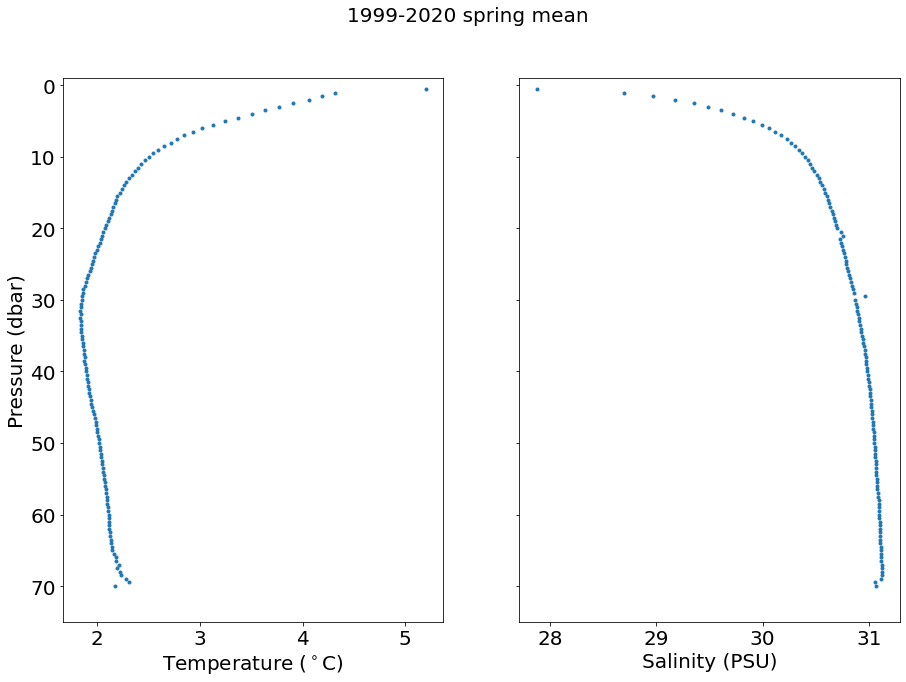

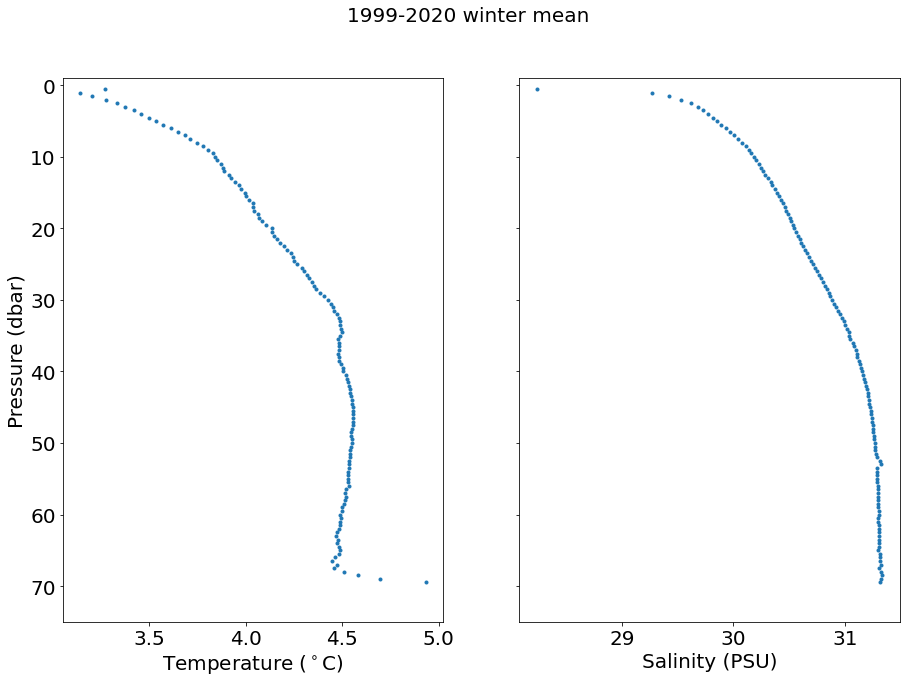

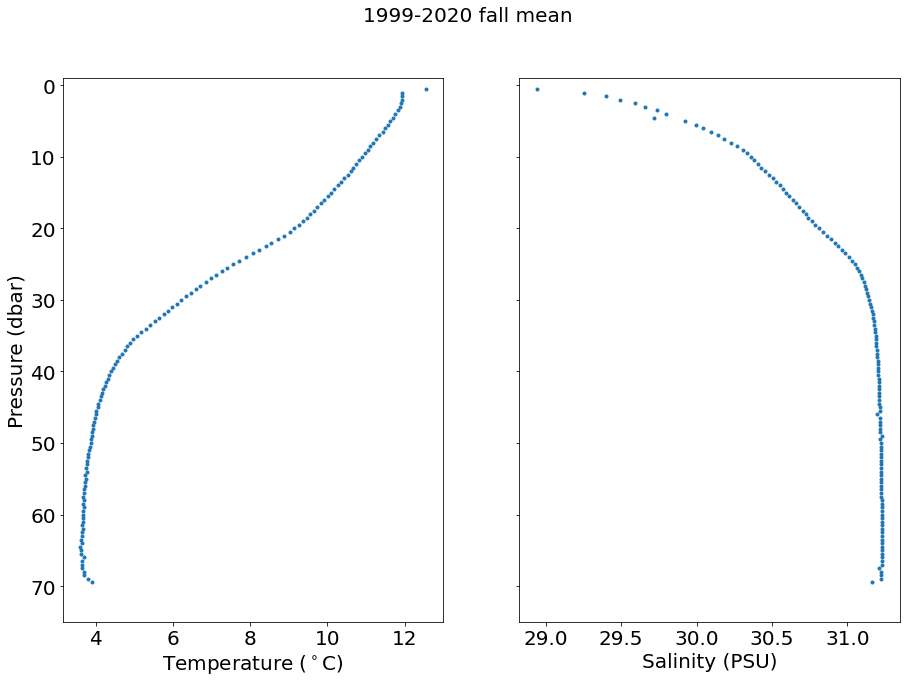

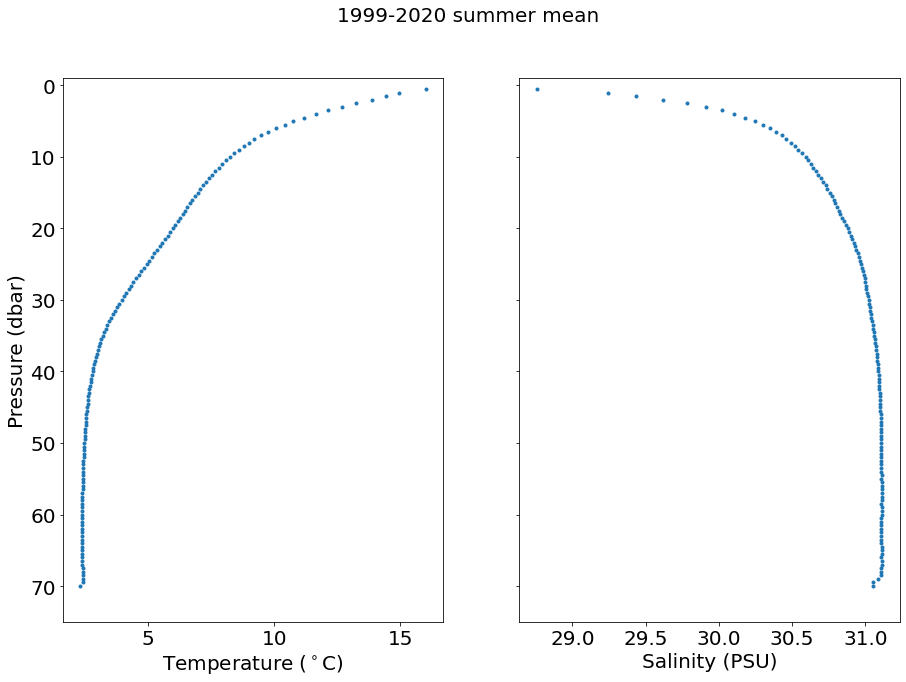

In [4]:

#seasonal mean
##                FIGURES 17-20
plt.close()
seasonal_mean={}
seasonal_mean['T']={}
seasonal_mean['S']={}
for v in seasonal_mean.keys():
    seasonal_mean[v]['spring'] = np.empty([1, len(ds.pressure.values)])
    seasonal_mean[v]['spring'][:] = np.nan
    seasonal_mean[v]['winter'] = np.empty([1, len(ds.pressure.values)])
    seasonal_mean[v]['winter'][:] = np.nan
    seasonal_mean[v]['fall'] = np.empty([1, len(ds.pressure.values)])
    seasonal_mean[v]['fall'][:] = np.nan
    seasonal_mean[v]['summer'] = np.empty([1, len(ds.pressure.values)])
    seasonal_mean[v]['summer'][:] = np.nan

for v in seasonal_mean.keys():
    for s in seasonal_mean[v].keys():
        for w in range(len(which_season_weeks[s])-1):
            if v=='T':
                seasonal_mean[v][s]=np.append(seasonal_mean[v][s],szn_mean_T[which_season_weeks[s][w]].reshape(1,len(ds.pressure.values)), axis=0)

            else:
                seasonal_mean[v][s] = np.append(seasonal_mean[v][s], szn_mean_S[which_season_weeks[s][w]].reshape(1,len(ds.pressure.values)), axis=0)

#when we take the average along axis=0 of seasonal_mean, then we will have the seasonal mean.


which_season_mean_title={}
which_season_mean_title['spring']='1999-2020 spring mean'
which_season_mean_title['winter']='1999-2020 winter mean'
which_season_mean_title['fall']='1999-2020 fall mean'
which_season_mean_title['summer']='1999-2020 summer mean'
#plot the seasonal mean
for s in which_season_weeks.keys():
    #plt.clf()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
    ax1.plot(np.nanmean(seasonal_mean['T'][s], axis=0), ds.pressure.values, '.')
    ax2.plot(np.nanmean(seasonal_mean['S'][s], axis=0), ds.pressure.values, '.')
    ax1.set_ylim(75,-1)

    ax1.set_xlabel('Temperature ($^\circ$C)', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    ax2.set_xlabel('Salinity (PSU)', fontsize=20)
    ax1.set_ylabel('Pressure (dbar)', fontsize=20)
    plt.suptitle(which_season_mean_title[s], fontsize=20)


In [5]:
#pcolor plot timeseries

Text(0.5, 0.98, 'Bedford Basin climatology')

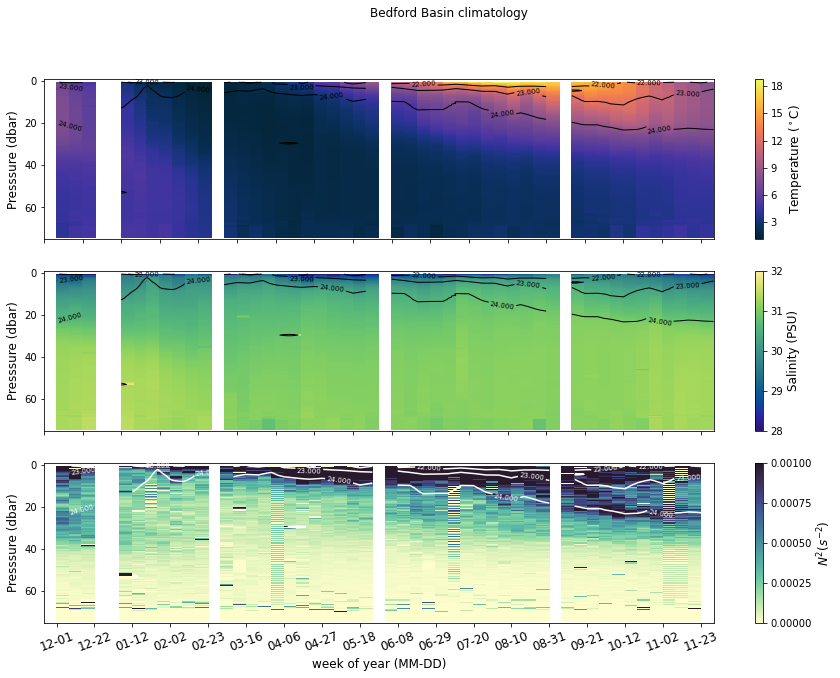

In [6]:

#
#towards making a pcolor plot of T and S with black isopycnals contoured onto it. season_weeks is the time axis
#

#putting it all together in one array with dims (week, depth)
clim_ts={}
clim_ts['T']=np.append(np.append(np.append(seasonal_mean['T']['winter'], seasonal_mean['T']['spring'], axis=0), seasonal_mean['T']['summer'], axis=0), seasonal_mean['T']['fall'], axis=0)
clim_ts['S']=np.append(np.append(np.append(seasonal_mean['S']['winter'], seasonal_mean['S']['spring'], axis=0), seasonal_mean['S']['summer'], axis=0), seasonal_mean['S']['fall'], axis=0)

#interpolating over the nans
for v in clim_ts.keys():
    for i in range(len(clim_ts[v])):
        nans, x= nan_helper(clim_ts[v][i])
        if len(clim_ts[v][i]) == len(clim_ts[v][i][nans]):
            clim_ts[v][i]=clim_ts[v][i]
        else:
            clim_ts[v][i][nans]=np.interp(x(nans), x(~nans), clim_ts[v][i][~nans])

#Gibbs seawater conversions
bb_lon=-63.632648
bb_lat=44.693491
clim_ts['SA']=gsw.SA_from_SP(clim_ts['S'],ds.pressure.values, bb_lon, bb_lat)

clim_ts['CT']=gsw.CT_from_t(clim_ts['SA'], clim_ts['T'], ds.pressure.values)

#do potential density and reference to 0
clim_ts['rho']=gsw.sigma0(clim_ts['SA'], clim_ts['CT'])

clim_ts['N2'], clim_ts['pmid']=gsw.Nsquared(clim_ts['SA'].T, clim_ts['CT'].T, ds.pressure.values.reshape(276,1), bb_lat)


####                FIGURE 21
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15, 10))
x_axis_time=np.arange(1,len(season_weeks)+1)
time, depth = np.meshgrid(x_axis_time, ds.pressure.values)
time_N2, depth_N2 = np.meshgrid(np.arange(len(season_weeks)), clim_ts['pmid'][:,0] )
rho_levels=np.array([22, 23, 24, 25])
rho_colors=np.array(['k', 'k', 'k', 'k', 'k', 'k', 'k'])
rho_colors_w=np.array(['white', 'white', 'white', 'white', 'white', 'white', 'white'])

ytix=np.array([0,20,40,60])
Ttix=np.array([3,6,9,12,15,18])
Stix=np.array([28, 29, 30, 31, 32])
N2tix=np.linspace(0,10e-4, 5)


im1=ax1.pcolormesh(time, depth, clim_ts['T'].T, cmap=cmocean.cm.thermal)
cs1=ax1.contour(time, depth, clim_ts['rho'].T, rho_levels, colors=rho_colors, linewidths=1)
ax1.clabel(cs1, rho_levels, fontsize=7)#, fmt='% 4d')
ax1.set_ylim(75,-1)
ax1.set_ylabel('Presssure (dbar)', fontsize=12)
ax1.set_xticks(x_axis_time[::3])
ax1.set_yticks(ytix)
ax1.set_xticklabels([])
ax1.tick_params(axis='x', labelsize=12)
H1=f.colorbar(im1, ax=ax1, ticks=Ttix)
H1.set_label('Temperature ($^\circ$C)', fontsize=12)

im2=ax2.pcolormesh(time, depth, clim_ts['S'].T, cmap=cmocean.cm.haline, vmin=28, vmax=32)
cs2=ax2.contour(time, depth, clim_ts['rho'].T, rho_levels, colors=rho_colors, linewidths=1)
ax2.clabel(cs2, rho_levels, fontsize=7)#, fmt='% 4d')
ax2.set_ylim(75,-1)
ax2.set_ylabel('Presssure (dbar)', fontsize=12)
ax2.set_yticks(ytix)
ax2.set_xticks(x_axis_time[::3])
ax2.set_xticklabels([])
ax2.tick_params(axis='x', labelsize=12)
H2=f.colorbar(im2, ax=ax2)#, ticks=Stix)
H2.set_label('Salinity (PSU)', fontsize=12)


im3=ax3.pcolormesh(time_N2, clim_ts['pmid'], clim_ts['N2'], cmap=cmocean.cm.deep, vmin=0, vmax=10e-4)
cs3=ax3.contour(time, depth, clim_ts['rho'].T, rho_levels, colors=rho_colors_w, linewidths=1.5)
ax3.clabel(cs3, rho_levels, fontsize=7)#, fmt='% 4d')
ax3.set_ylim(75,-1)
ax3.set_ylabel('Presssure (dbar)', fontsize=12)
ax3.set_yticks(ytix)
ax3.set_xticks(x_axis_time[::3])
ax3.set_xticklabels(season_weeks[::3], rotation=20)
ax3.set_xlabel('week of year (MM-DD)', fontsize=12)
ax3.tick_params(axis='x', labelsize=12)
H3=f.colorbar(im3, ax=ax3, ticks=N2tix)
H3.set_label('$N^2 (s^{-2})$', fontsize=12)

plt.suptitle('Bedford Basin climatology')